Nejjednodušší evoluční PDR (?) -- konvekce
==

Transport veličiny $u$ podél toku o rychlosti $v$ je popsán rovnicí
$$\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0$$

In [1]:
%matplotlib inline
from pylab import *
from numpy import *

In [2]:
#dimensions of the computational domain:
maxx = 10.
maxt = 20.

#flow velocity
v = 0.5

We discretize the simulation domain:
$$t_n = t_0 + n\Delta t$$
$$x_i = x_0 + i\Delta x$$
and seek for the numerical approximation $U^n_i$ to the actual solution $U(t_n, x_i)$ on the grid points

In [3]:
#discretization parameters
nx = 100   # number of unknown grid points in spatial direction
CFL = 1.0  # Courant constant v*dt/dx

def wave_init(maxx, maxt, v, nx, CFL):
    #choose time step according to CFL condition
    dx = maxx/(nx+1)
    dt = CFL*dx/v
    nt = int(maxt/dt)+1
    
    #define array for storing the solution
    U = zeros((nt, nx+2))
    
    x = arange(nx+2)*dx
    t = arange(nt)*dt
    return U, dx, dt, x, t

To obtain an explicit scheme for propagating the solution in time, we may replace the derivatives with forward differences in time and central differences in space (FTCS)
$$\frac{U^{n+1}_i-U^n_i}{\Delta t} + c\frac{U^n_{i+1}-U^n_{i-1}}{2\Delta x}=0.$$
This leads to a simple explicit formula for $U^{n+1}_i$
$$U^{n+1}_i = U^n_i - \frac{c\Delta t}{2\Delta x}(U^n_{i+1}-U^n_{i-1})$$

In [4]:
def convection_solve(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    for it in range(0,nt-1):
        U[it+1,xint] = U[it,xint] - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint-1])

Let's try to propagate a square initial condition

(0.0, 1.1)

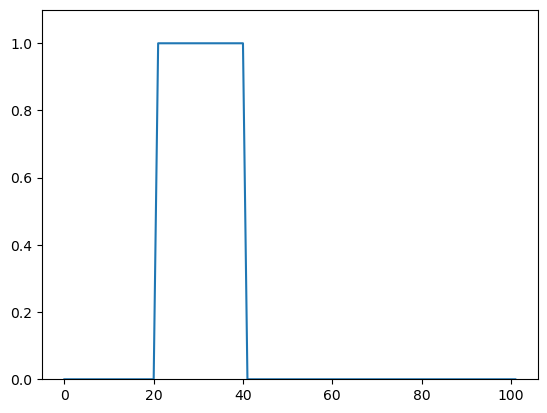

In [5]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
#U[0,:] = sin(x*5)
plot(U[0,:])
ylim(0,1.1)

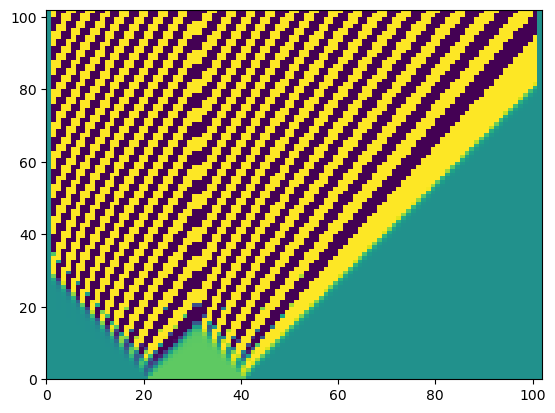

In [6]:
convection_solve(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

:-( Does it help if we choose smaller time step?

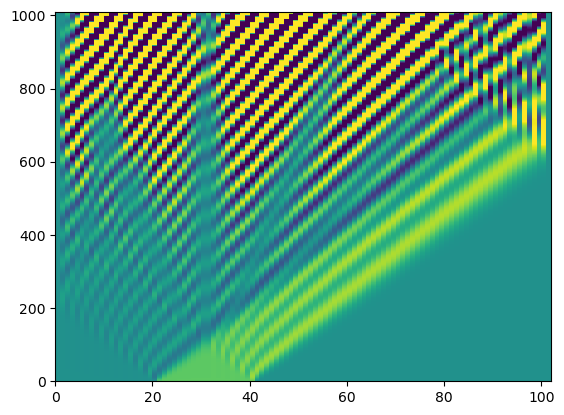

In [7]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

Not really, this solver fails to reproduce the expected solution. See Von Neumann stability analysis or matrix method...

The Lax(-Friedrichs) method stabilizes the solution by replacing $U^n_i$ with centered approximation $\frac{1}{2}(U^n_{i-1}+U^n_{i+1})$:
$$U^{n+1}_i = \frac{1}{2}(U^n_{i-1}+U^n_{i+1}) - \frac{c\Delta t}{2\Delta x}(U^n_{i+1}-U^n_{i-1})$$

In [8]:
def convection_solve_Lax(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    for it in range(0,nt-1):
        U[it+1,xint] = 0.5*(U[it,xint+1]+U[it,xint-1]) - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint-1])

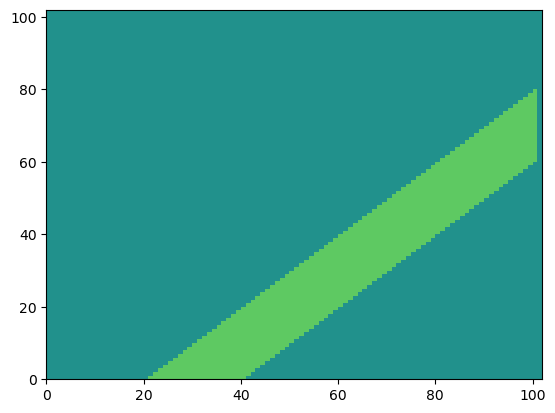

In [9]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_Lax(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

The Courant-Friedrichs-Lewy (CFL) condition
$$\frac{v\Delta t}{\Delta x}\leq 1$$
determines the stability. Look at the sensitivity to violating this condition:

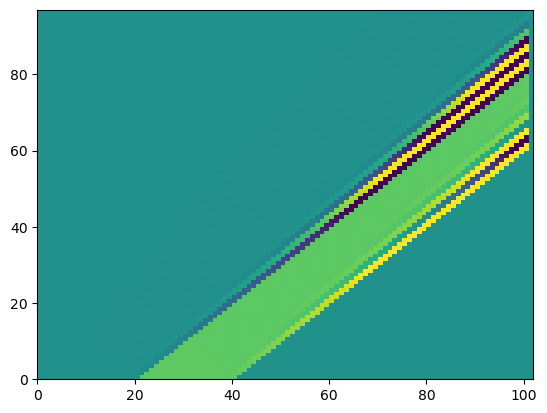

In [10]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=1.05)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_Lax(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

What if we need better time resolution?

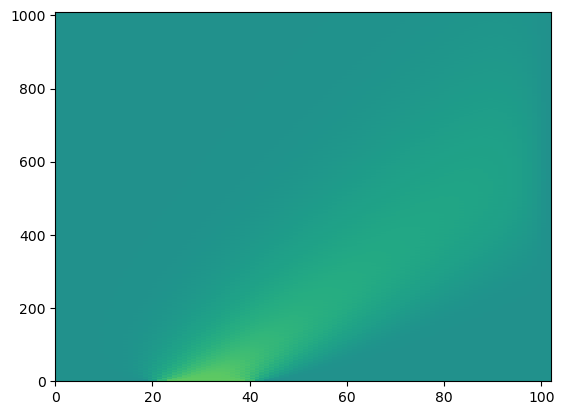

In [11]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_Lax(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

The stabilization also causes "damping" of the solution at smaller time steps.

In [12]:
def convection_solve_upwind(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    for it in range(0,nt-1):
        U[it+1,xint] = U[it,xint] - v*dt/dx*(U[it,xint] - U[it, xint-1])

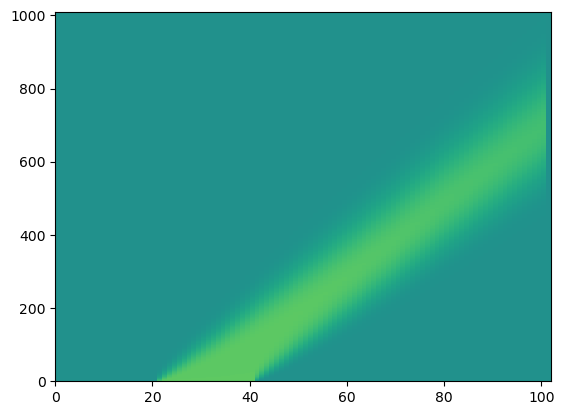

In [13]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_upwind(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

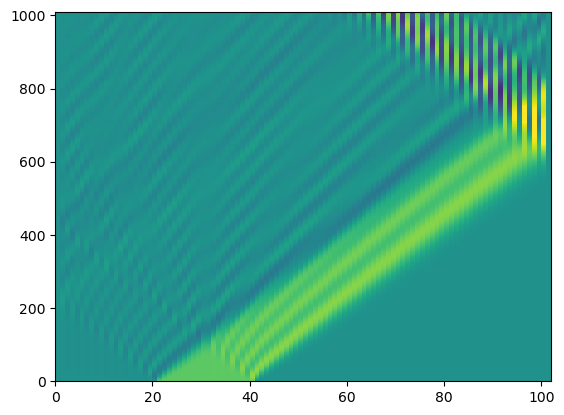

In [14]:
def convection_solve_LeapFrog(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    #start the solution with upwind method
    U[1,xint] = U[0,xint] - v*dt/dx*(U[0,xint] - U[0, xint-1])
    for it in range(1, nt-1):
        U[it+1,xint] = U[it-1,xint] - v*dt/dx*(U[it,xint+1] - U[it, xint-1])

U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LeapFrog(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

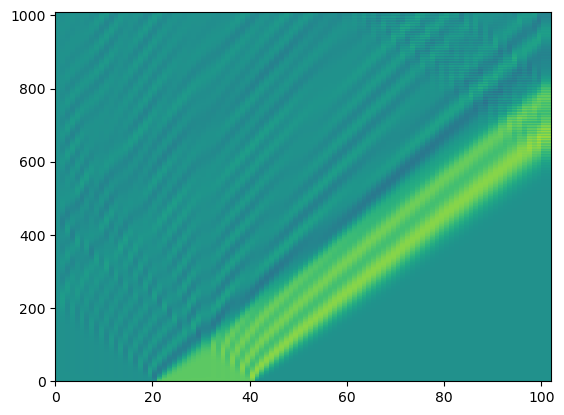

In [15]:
def convection_solve_LeapFrog(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    #start the solution with upwind method
    U[1,xint] = U[0,xint] - v*dt/dx*(U[0,xint] - U[0, xint-1])
    for it in range(1, nt-1):
        U[it+1,xint] = U[it-1,xint] - v*dt/dx*(U[it,xint+1] - U[it, xint-1])
                
        #extrapolate values on the outflow boundary
        U[it+1,-1] = U[it+1, -2]
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LeapFrog(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

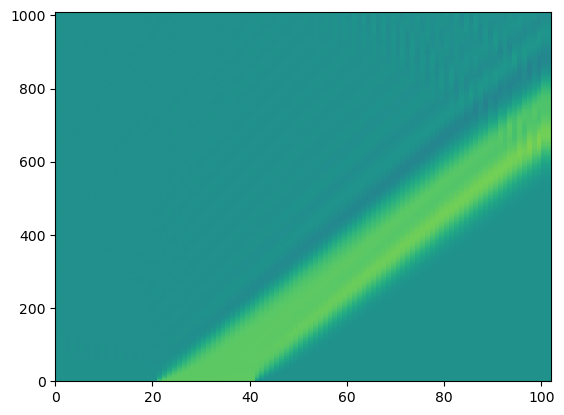

In [16]:
def convection_solve_LeapFrog(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    n_equilib = 50
    #start and smooth the solution with upwind method
    for it in range(0, min((n_equilib, nt-1))):
        U[it+1,xint] = U[it,xint] - v*dt/dx*(U[it,xint] - U[it, xint-1])
        #U[it+1,xint] = 0.5*(U[it,xint+1]+U[it,xint-1]) - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint-1])
    for it in range(min((n_equilib, nt-1)), nt-1):
        U[it+1,xint] = U[it-1,xint] - v*dt/dx*(U[it,xint+1] - U[it, xint-1])
                
        #extrapolate values on the outflow boundary
        U[it+1,-1] = U[it+1, -2]*2 - U[it+1, -3]
        U[it+1,-1] = U[it+1, -2]
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LeapFrog(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

In [17]:
def convection_solve_LaxWendroff(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    for it in range(0,nt-1):
        # less efficient but more readable:
        Uplus  = 0.5*(U[it,xint+1] + U[it, xint]) - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint])
        Uminus = 0.5*(U[it,xint] + U[it, xint-1]) - 0.5*v*dt/dx*(U[it,xint] - U[it, xint-1])
        U[it+1,xint] = U[it,xint] - v*dt/dx*(Uplus - Uminus)

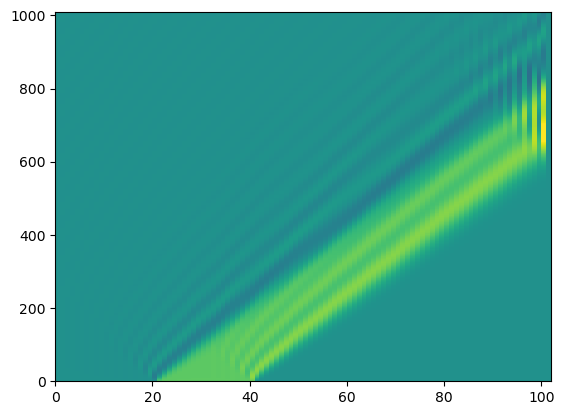

In [18]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LaxWendroff(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

In [19]:
def convection_solve_LaxWendroff(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    for it in range(0,nt-1):
        # less efficient but more readable:
        Uplus  = 0.5*(U[it,xint+1] + U[it, xint]) - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint])
        Uminus = 0.5*(U[it,xint] + U[it, xint-1]) - 0.5*v*dt/dx*(U[it,xint] - U[it, xint-1])
        U[it+1,xint] = U[it,xint] - v*dt/dx*(Uplus - Uminus)
        
        #extrapolate values on the outflow boundary
        U[it+1,-1] = U[it+1, -2]*2 - U[it+1,-3]

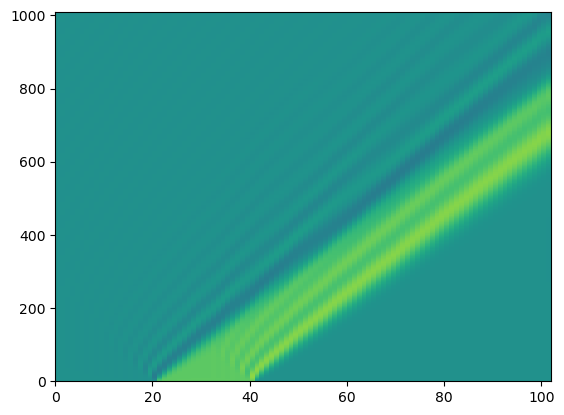

In [20]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LaxWendroff(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

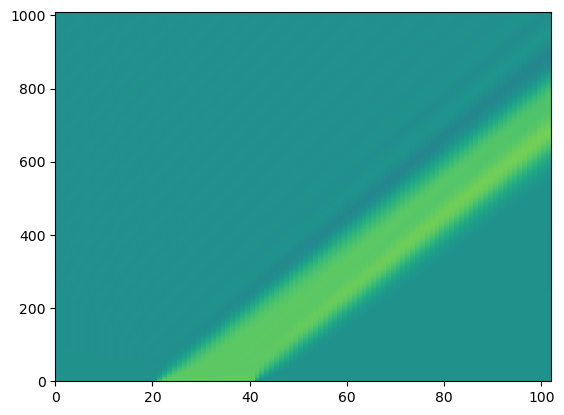

In [21]:
def convection_solve_LaxWendroff(U, dx, dt, nx, nt):
    xint = arange(1, nx+1)
    n_equilib = 50
    for it in range(0, min((n_equilib, nt-1))):
        U[it+1,xint] = U[it,xint] - v*dt/dx*(U[it,xint] - U[it, xint-1])
    for it in range(min((n_equilib, nt-1)), nt-1):
        # less efficient but more readable:
        Uplus  = 0.5*(U[it,xint+1] + U[it, xint]) - 0.5*v*dt/dx*(U[it,xint+1] - U[it, xint])
        Uminus = 0.5*(U[it,xint] + U[it, xint-1]) - 0.5*v*dt/dx*(U[it,xint] - U[it, xint-1])
        U[it+1,xint] = U[it,xint] - v*dt/dx*(Uplus - Uminus)
        
        #extrapolate values on the outflow boundary
        U[it+1,-1] = U[it+1, -2]*2 - U[it+1,-3]

U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=.1)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_LaxWendroff(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

Can we break the CFL condition with some naive implementation of implicit scheme?

In [22]:
from scipy.sparse import dia_matrix, eye
from scipy.sparse.linalg import factorized
def d1matrix(nelem):
    elements = ones((3,nelem))
    elements[1,:] *= 0
    elements[0,:] *= -1
    return dia_matrix((elements, [-1,0,1]), shape=(nelem,nelem)).tocsc()

def convection_solve_CN(U, dx, dt, nx, nt):
    alpha = -v*dt/(dx*4.)
    M1 = eye(nx)-d1matrix(nx)*alpha
    M2 = eye(nx)+d1matrix(nx)*alpha
    LU = factorized(M1.tocsc())
    for it in range(0,nt-1):
        U[it+1,1:-1] = LU(M2.dot(U[it,1:-1]))
        
        #extrapolate values on the outflow boundary
        U[it+1,-1] = U[it+1, -2]

        

In [23]:
from scipy import sparse

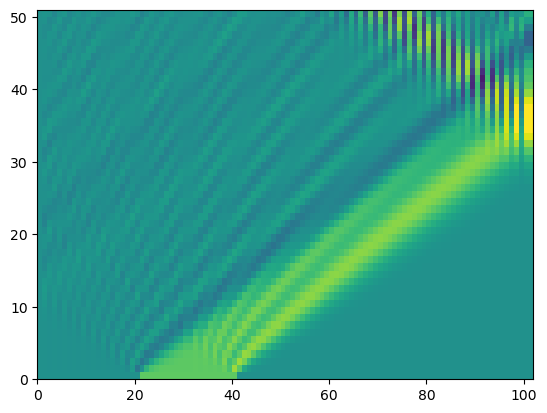

In [24]:
U, dx, dt, x, t = wave_init(maxx, maxt, v, nx, CFL=2)
U[0,:] = 0.
U[0, (x<maxx*0.4) & (x>maxx*0.2)] = 1.
convection_solve_CN(U, dx, dt, nx, len(t))
pcolormesh(U, rasterized=True, vmin=-2, vmax=2)

It sort of works, but not very well...